## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [250]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import WeightedRandomSampler
import os
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from sklearn.metrics import recall_score, accuracy_score, f1_score
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
import copy
%matplotlib inline

In [251]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [252]:
model = CustomNeuralNetwork()

In [253]:
#Dataloader code from Checkpoint #1
resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(256), int(256))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
        
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((256, 256)),
    # # T.RandomSolarize(2, p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    # # T.RandomRotation(15),
    # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0], std=[1])
])

training_data = XRayDataset(train_path, resize)
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)


# article on batch sizes 
#https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15

batch_s = 8

# Create weighted sampler
counts = {'test': {'PNEUMONIA': 390, 'NORMAL': 234},
 'train': {'PNEUMONIA': 3875, 'NORMAL': 1341},
 'val': {'PNEUMONIA': 8, 'NORMAL': 8}}

train_weights = [1/v for v in counts['train'].values()]
train_sampler = WeightedRandomSampler(weights=train_weights,num_samples=2)
val_weights = [1/v for v in counts['val'].values()]
val_sampler = WeightedRandomSampler(weights=val_weights,num_samples=2)

train_dataloader = DataLoader(training_data, batch_size=batch_s, shuffle=True) # had to get rid of shuffle to use random sampler
val_dataloader = DataLoader(val_data, batch_size=batch_s, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_s, shuffle=True)



In [254]:
# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler_lr = StepLR(optimizer, 
                   step_size = 4, # Period of learning rate decay
                   gamma = 0.5)

scheduler_eilr = ExponentialLR(optimizer, 
                          gamma = 0.5) # Multiplicative factor of learning rate decay.

EPOCHS = 20

In [255]:
# 4: Train and validate the network
train_losses = []
train_accuracies = []
train_recalls = []
val_accuracies = []
val_recalls = []
val_losses = []
val_running_loss = []

for epoch in range(EPOCHS):
    # TRAIN
    model.train()  # Make sure gradient tracking is on, and do a pass over the data
    running_loss = 0.0
    y_true = np.array([])
    y_predict = np.array([])
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        running_loss += loss.item()
        y_true = np.concatenate((y_true, labels_tensor.numpy()))
        y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        y_predict = np.concatenate((y_predict, y_pred_batch))
    
    epoch_accuracy = accuracy_score(y_true, y_predict)
    epoch_recall = recall_score(y_true, y_predict, average='binary')
    train_losses.append(running_loss)
    train_accuracies.append(epoch_accuracy)
    train_recalls.append(epoch_recall)

    #VALIDATION
    if (epoch+1) // 5 == 0: 
        with torch.no_grad():
            model.eval() 

         # # we don't want to keep track of the gradients in the validation part
            y_true_val = np.array([])
            y_predict_val = np.array([])
            for i, data in enumerate(val_dataloader):
            # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                outputs = model(inputs)  # forward pass
                label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
                labels_tensor = torch.tensor([label_dict[label] for label in labels])
                y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
                y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))

            val_epoch_accuracy = accuracy_score(y_predict_val, y_true_val)
            val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
            val_losses.append(val_running_loss)
            val_accuracies.append(val_epoch_accuracy)
            val_recalls.append(val_epoch_recall)



In [ ]:
# y_predict, y_true, train_losses, train_accuracies, train_recalls = train(model)
print("y_predict", y_predict)
print("y_true", y_true)
print(train_losses)
print("Training accuracies",train_accuracies)
print("Training recalls", train_recalls)

print("Validation accuracies",val_accuracies)
print("Validation recalls", val_recalls)

y_predict [0. 0.]
y_true [0. 0.]
[0.6872940063476562, 0.6494584083557129, 0.6007949113845825, 0.3774811625480652, 0.25190606713294983, 0.153072789311409, 0.08591291308403015, 0.04680103808641434, 0.8477045297622681, 0.018643269315361977, 0.4770303964614868, 0.3582264184951782, 0.35732752084732056, 0.010910851880908012, 0.3556392192840576, 0.3545191287994385, 0.007023940794169903, 0.0058717853389680386, 0.0049859946593642235, 0.004366388078778982]
Training accuracies [0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
Training recalls [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Validation accuracies [1.0, 1.0, 1.0, 1.0]
Validation recalls [0.0, 0.0, 0.0, 0.0]


In [ ]:
print(val_accuracies)
print(val_recalls)

unique, counts = np.unique(y_predict_val, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

[1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0]
0.0: 2


In [ ]:
#5. Test model
test_losses = []
test_running_loss = []
test_accuracies = []
test_recalls = []

with torch.no_grad():
    model.eval()
    y_true_test = np.array([])
    y_predict_test = np.array([])
    for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
        y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))

    test_epoch_accuracy = accuracy_score(y_true_test, y_predict_test)
    test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
    test_losses.append(test_running_loss)
    test_accuracies.append(test_epoch_accuracy)
    test_recalls.append(test_epoch_recall)

KeyboardInterrupt: 

In [ ]:
print("test accuracy", test_accuracies)
print("test recall", test_recalls)

unique, counts = np.unique(y_predict_test, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


test accuracy [0.375]
test recall [1.0]
1.0: 624


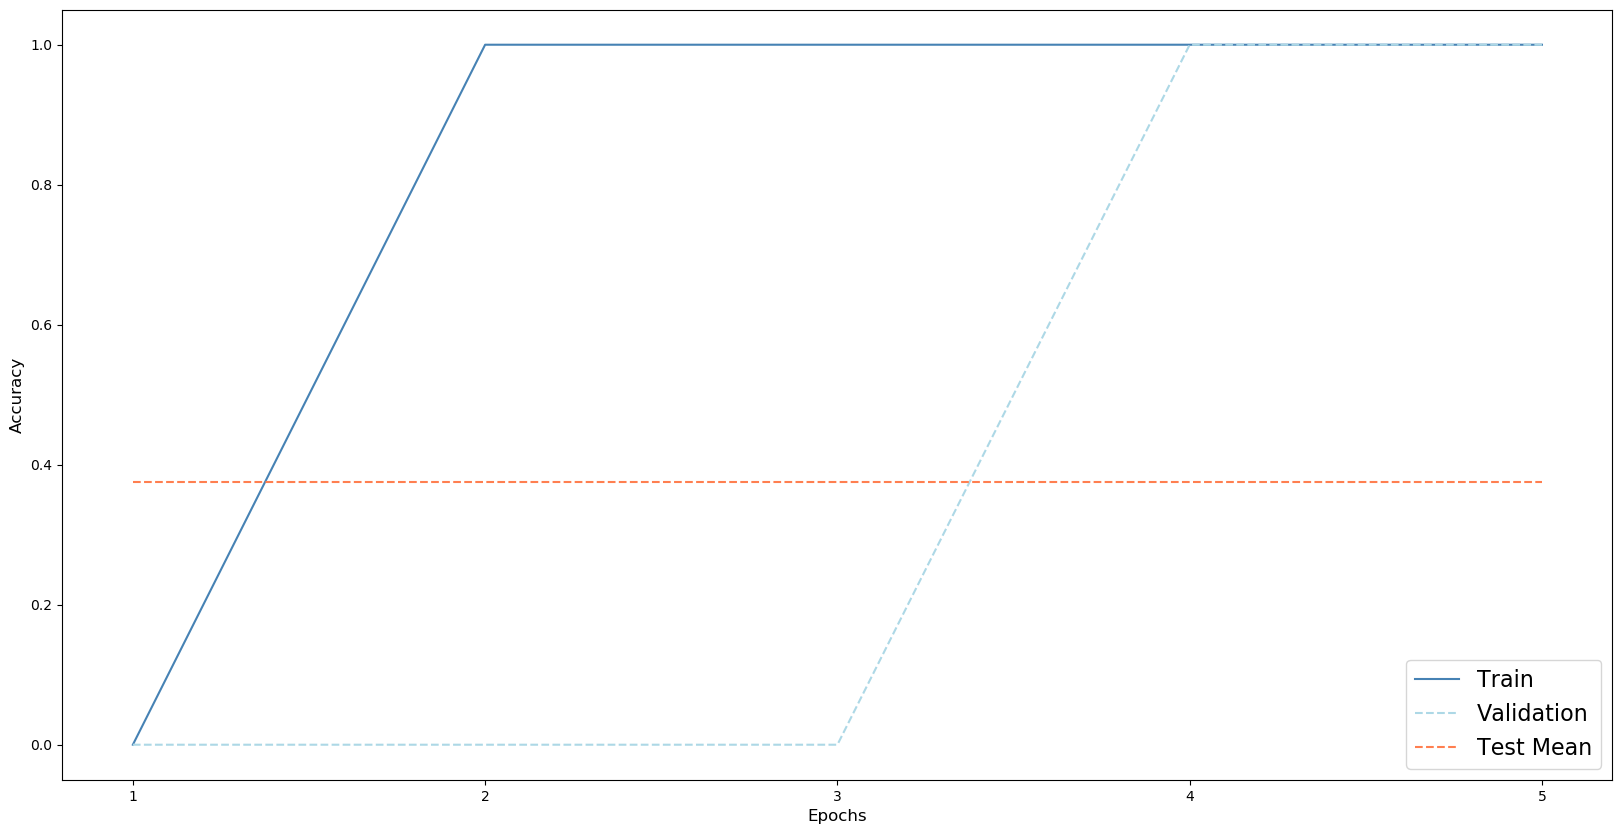

In [ ]:
test_accuracy =  test_accuracies * EPOCHS  
epochs = [i for i in range(1,EPOCHS+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracy, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
plt.show()

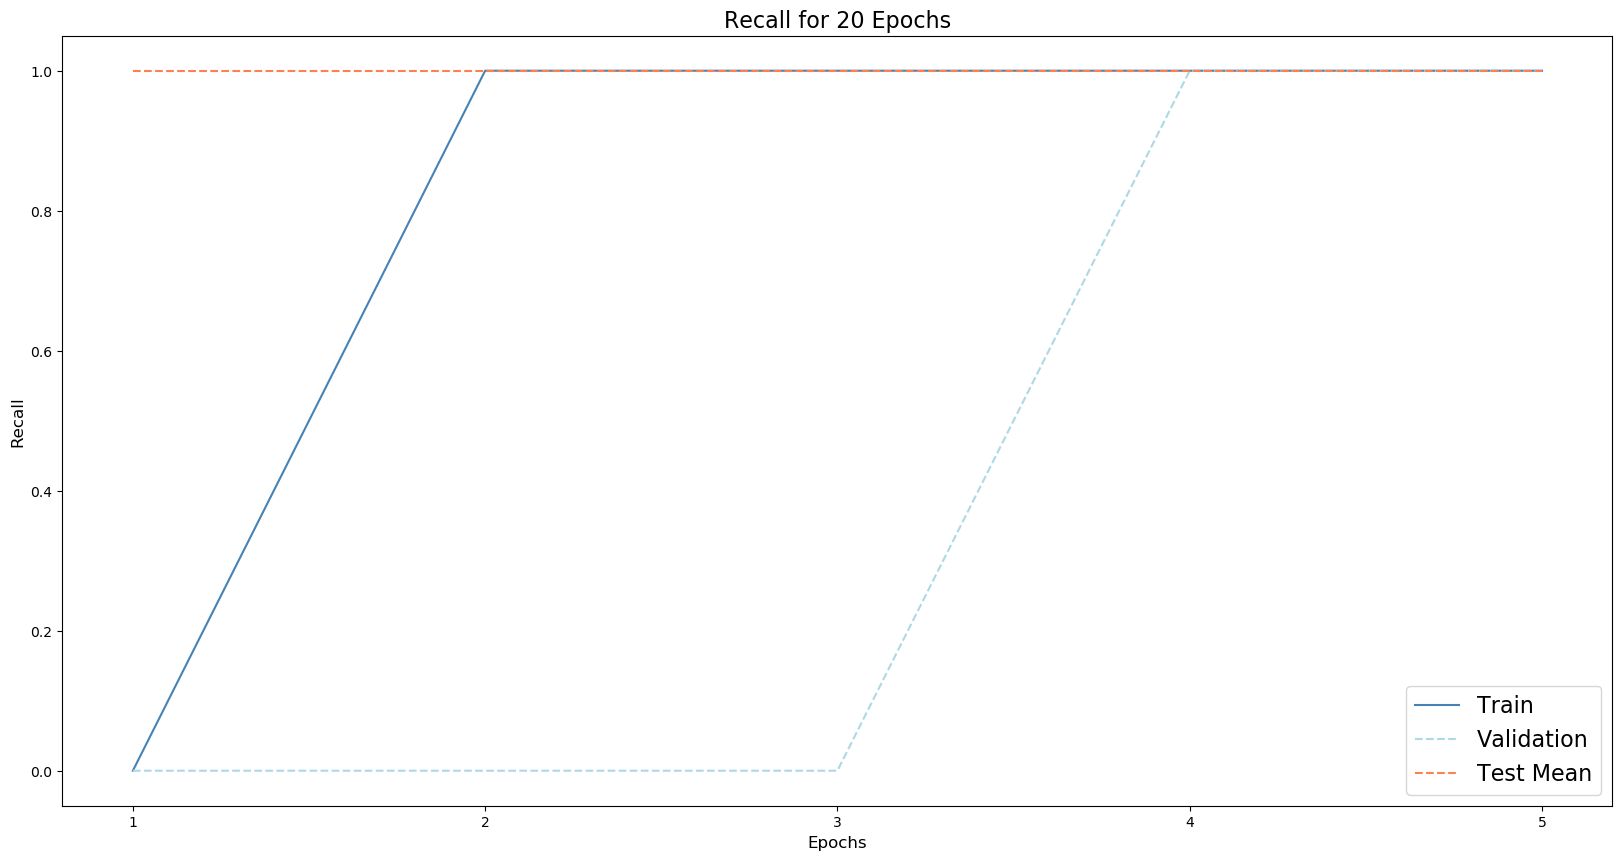

In [ ]:
test_recalls_list = test_recalls * EPOCHS
epochs = [i for i in range(1,EPOCHS+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_list, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
ax.set_title("Recall for 20 Epochs", fontsize=16)
plt.show()